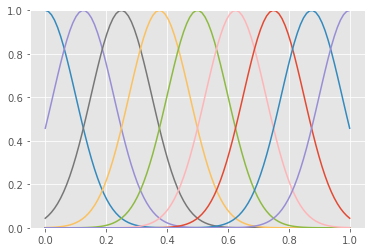

In [26]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import linalg as LA
from scipy.stats import norm
plt.style.use("ggplot")

N = 8
M = 10
def gaussian_basis(x):
  # M - dimension
  gamma = 50
  x_ = np.linspace(0,1,M-1)
  return np.append(1, np.exp(-(x - x_)**2 * gamma))

X = np.linspace(0,1,100)
Y = np.array([gaussian_basis(x) for x in X]) #(N,M)
plt.plot(X,Y)
plt.ylim(0,1)
plt.show()

# データセットを作る
- ロジスティクス回帰を変分近似で解く

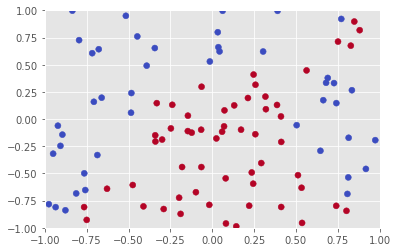

In [27]:
N = 100
train_X = np.zeros((N, 2)) #(N,2)
train_X[:,0] = np.random.uniform(-1,1,N)
train_X[:,1] = np.random.uniform(-1,1,N)
train_t =((train_X[:,0]**3 - train_X[:,1]**2)*(train_X[:,0] - train_X[:,1]) < 0.05)
plt.scatter(train_X[:,0], train_X[:,1], c=train_t, cmap=cm.coolwarm)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

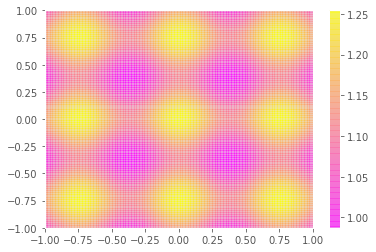

In [28]:
basis_num = 5
dims = basis_num ** 2

def gaussian_basis(x,y,cx,cy):
  gamma = 5
  return np.exp( -((x - cx)**2 + (y - cy)**2) * gamma )

basis_center = [(x, y) for x in np.linspace(-1.5, 1.5, basis_num) for y in np.linspace(-1.5, 1.5, basis_num)]

def phi(x,y):
  return np.array([gaussian_basis(x,y,cx,cy) for cx, cy in basis_center])

X, Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
Z = np.vectorize(lambda x,y: phi(x,y).sum())(X,Y)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.pcolor(X,Y,Z,alpha=0.4, cmap=cm.spring)
plt.colorbar()
plt.show()

In [29]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

Phi = phi(train_X[:,0], train_X[:,1]).T
print(Phi.shape)

(100, 25)


In [30]:
def graph(f):
    X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    Z = np.vectorize(f)(X,Y)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.pcolor(X, Y, Z, alpha=0.3)
    plt.colorbar()
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_t, cmap=cm.coolwarm, alpha=0.8)
    plt.title("iter=" + str(count))
    plt.show()

In [31]:
def mu_a(x,y):
  return m_N.T@phi(x,y)

def sigma2_a(x,y):
  return phi(x,y).T @ S_N @ phi(x,y)

def K(x):
  return (1 + x * np.pi / 8)

def ans_dist(x,y):
  return sigmoid(K(sigma2_a(x,y)) * mu_a(x,y))

In [32]:
train_t.astype(float)

array([1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.])

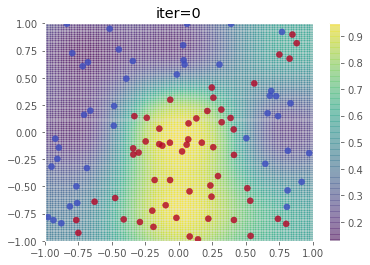

In [36]:
m_0 = np.zeros(dims)
alpha = 1
S_0 = alpha * np.eye(dims)
S_O_inv = np.eye(dims) / alpha

var_para = np.ones(N)

count = 0
max_iter = 100

def LAM(x):
  return (sigmoid(x) - 0.5) / (2*x)

for i in range(max_iter):
  # E step
  S_N = LA.inv( S_O_inv + 2 * ((np.c_[LAM(var_para)]* Phi).T @ Phi) )
  m_N = S_N @ (S_O_inv@m_0 + (train_t.astype(float) - 0.5).T @ Phi)

  # M step
  var_para_ =np.sqrt([Phi[i].dot(S_N + np.outer(m_N, m_N)).dot(Phi[i]) for i in range(N)])
  if LA.norm(var_para_ - var_para) / LA.norm(var_para)  < 0.0001:
    graph(ans_dist)
    break
  var_para = var_para_

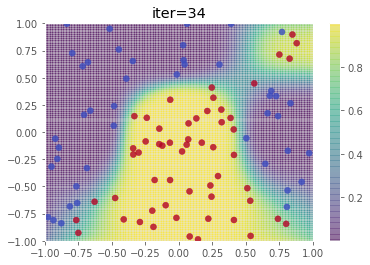

In [35]:
#無情報事前分布
a_0 = 0
b_0 = 0
 
#1: 変分パラメータ初期化
xi = np.ones(N)
E_alpha = 1
 
count = 0
max_iter = 100
for i in range(max_iter):
    #2: q(w)を更新
    Lam = np.diag((sigmoid(xi) - 0.5) / (2*xi))
    S_N_inv = E_alpha * np.eye(dims) + 2 * Phi.T.dot(Lam).dot(Phi)
    S_N = LA.inv(S_N_inv)
    m_N = S_N.dot(Phi.T.dot(train_t - 0.5))
 
    #3: q(α)を更新
    a_N = a_0 + dims / 2.
    b_N = b_0 + (m_N.dot(m_N) + np.diag(S_N).sum()) / 2.
    E_alpha = a_N / b_N
 
    #4: ξを更新
    xi_ = np.sqrt([Phi[i].dot(S_N + np.outer(m_N, m_N)).dot(Phi[i]) for i in range(N)])
    #print xi_[0]
 
    #5: 収束条件
    count += 1
    if LA.norm(xi_ - xi) / LA.norm(xi) < 0.01:
        graph(ans_dist)
        break
    xi = xi_
 